# 可解释公平指标

## 实验基本环境设置

In [1]:
%matplotlib inline
# 导入依赖
import numpy as np
import pandas as pd
from rich import print
import matplotlib.pyplot as plt

In [2]:
# 字体设置
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Microsoft YaHei"]

## 自定义函数

In [3]:
# 导入自定义函数
%load_ext autoreload
%autoreload 2
from utils.helper import fairness_metrics, test_model  # 测试各种指标并输出图像
from utils.shap_helper import get_ext_train_comp_by_k
from model.models import train_model_and_test
from mydata.adult_0518 import (
    X_train,
    y_train,
    X_test,
    y_test,
    sex,
    feature_index,
    idxs_loc_male,
    idxs_loc_female,
    X_train_male,
    y_train_male,
    X_train_female,
    y_train_female
)  # 获得 数据集 测试集 和 测试集上的敏感属性

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
import xgboost

xgboost_origin, res_origin = train_model_and_test(
    X_train,
    y_train,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="原始组",
)

In [5]:
res_origin

{'准确率[1.]': 0.8624219469751254,
 '精确率[1.]': 0.7683765203595981,
 '召回率[1.]': 0.6159389571852479,
 'FPR[0.]': 0.05910931174089069,
 'FNR[0.]': 0.384061042814752,
 'F1 Score[1.]': 0.6837647058823529,
 '人口平等 差异[0.]': 0.16989595884523423,
 '人口平等 比率[1.]': 0.32250719180485066,
 '机会均等 差异[0.]': 0.08764799066199769,
 '机会均等 比率[1.]': 0.29597011190360795}

In [6]:
import shap
def get_shapley_value(model, X_train):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)
    return shap_values
shap_values = get_shapley_value(xgboost_origin, X_train)

In [7]:
values = shap_values.values
values.shape

(22792, 14)

In [8]:
# 首先从 X_train 获得
idxs_iloc_male = X_train.index.get_indexer(idxs_loc_male)
idxs_iloc_female = X_train.index.get_indexer(idxs_loc_female)
idxs_iloc_male
# todo 使用 SGII 和 SDIG
# 使用 idxs_male 找到 idxs （能对应上 shapley value 中）

array([ 3444, 15723, 16458, ..., 12882, 13343, 10463], dtype=int64)

In [9]:
0 in idxs_iloc_male

False

In [10]:
from utils.new_index_0518 import shapley_distance_between_individual_and_individual as sdii
from utils.new_index_0518 import shapley_distance_between_individual_and_group as sdig
from utils.new_index_0518 import shapley_distance_between_group_and_group as sdgg
sv_male = values[idxs_iloc_male] # 找到了 male 的 shapley_value
sv_female = values[idxs_iloc_female]
A = np.array([feature_index])

In [11]:
import os


def load_or_run_svgg_and_save(
    X,
    A,
    date,
    title,
    dir="np-cache",
):
    filename = f"{date}-{title}"
    filepath = f"{dir}/{filename}.npy"
    print("文件名为: ", filename)
    print("文件路径为: ", filepath)


    if os.path.exists(filepath):
        print("发现缓存数据，直接载入")
        return np.load(filepath)
    print("未发现相关缓存")
    res = sdgg(X, A)
    np.save(filepath, res)
    print("缓存成功")
    return res

In [13]:
res_female = load_or_run_svgg_and_save(sv_female, A, date="2024-05-19", title="11min-可解释指标-sv-female")

文件名为:  2024-05-19-11min-可解释指标-sv-female

文件路径为:  np-cache/2024-05-19-11min-可解释指标-sv-female.npy

发现缓存数据，直接载入

In [14]:
res_male = load_or_run_svgg_and_save(sv_female, A, date="2024-05-19", title="50min-可解释指标-sv-male")

文件名为:  2024-05-19-50min-可解释指标-sv-male

文件路径为:  np-cache/2024-05-19-50min-可解释指标-sv-male.npy

发现缓存数据，直接载入

In [15]:
res_male_arg_sorted = np.argsort(res_male)
res_male_arg_sorted, res_male_arg_sorted.shape

(array([ 3766,  1169,  1806, ..., 12995,   589,   119], dtype=int64), (15310,))

In [16]:
k = 10

In [17]:
res_male[res_male_arg_sorted[-k:]]

array([0.04789126, 0.04857429, 0.04890539, 0.04927978, 0.04949509,
       0.05132355, 0.05461958, 0.05793066, 0.06561241, 0.07874709])

In [18]:
def plt_hist_freq(x, bins=20, xlabel="xlabel", ylabel="ylabel", title="title"):
    # 画分布图
    counts, bins, _ = plt.hist(x, bins=bins, alpha=0.7, width=0.005)  # 设置直方图的柱子数量
    plt.plot((bins[:-1] + bins[1:]) / 2, counts, "-ro", alpha=0.3)
    plt.xlabel(xlabel)  # x轴标签
    plt.ylabel(ylabel)  # y轴标签
    plt.title(title)  # 图表标题

    # 在每个柱子上显示频率数
    for i in range(len(counts)):
        if counts[i] > 0:
            plt.text(bins[i], counts[i], str(counts[i]), ha="center", va="bottom")
    plt.show()

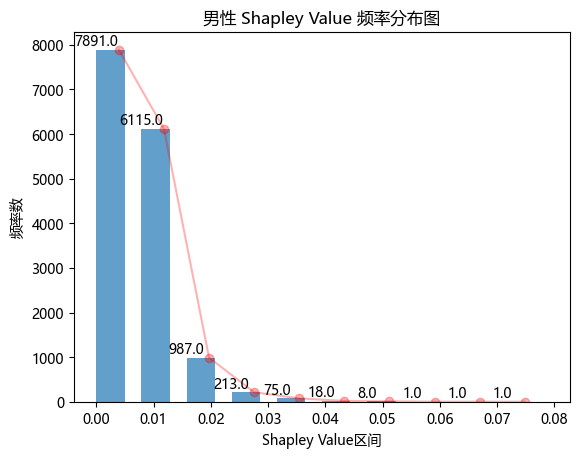

In [19]:
plt_hist_freq(res_male, 10, xlabel="Shapley Value区间", ylabel="频率数", title="男性 Shapley Value 频率分布图")

In [ ]:
# 统计大于阈值的个数
t = 0.04
count = np.sum(res_male > t)
count

24

In [ ]:
# 统计大于阈值的 index
res_male_t_indices = np.where(res_male > t)
res_male_t_indices

(array([    4,   119,   177,   589,  2320,  2531,  2705,  5950,  6167,
         6553,  6769,  6926,  7748,  7851,  7909,  9350,  9880, 10855,
        11019, 11507, 11731, 12090, 12371, 12995], dtype=int64),)

In [ ]:
# 从 res_male 中剔除这些 indices
# ==> params
X = sv_male
idx = res_male_t_indices
# ==> def
# 给定 X 和 idx，选择不在 idx 中的 X 子集
selected_X = X[np.isin(np.arange(len(X)), idx, invert=True)]
# <== end
fair_sv_male = selected_X
fair_sv_male.shape, sv_male.shape, len(res_male_t_indices[0])

((15286, 14), (15310, 14), 24)

In [ ]:
# 使用 Knn 算法找到最近邻的 k 个样本（但是是使用 shapley value 找近邻的），可能会有点问题
from sklearn.neighbors import NearestNeighbors 
# ==> params
X = fair_sv_male
target = sv_male[res_male_t_indices]
# ==> def
knn = NearestNeighbors(n_neighbors=7)
knn.fit(X)
distances, indices = knn.kneighbors(target)
# <== end
indices

array([[   21,     1,     3,    17,     6,    16,    28],
       [11911,  7469, 11847,  9619,  3604,  2793,  3173],
       [  716,   186,   667, 10801,   587,  6678,   791],
       [ 4711,  6295, 11194, 13915, 14656,  7077,  3135],
       [14146,  6446,  4845,  4711, 14656, 10276,  5918],
       [10293,  4644,  9855,  3177, 13915, 13223,  2617],
       [ 4845,  6446, 10276,  4711, 11307,  5409,  9664],
       [ 8767,  3673,  9320, 10642,  7567,  9664, 10046],
       [10705,  2930,  6597,  8044,  9825,  9827,  3382],
       [10733, 11596,  9664,  4774,  3798, 12092, 14063],
       [11145,  6744,  7198,  2614,  5002, 10015, 14680],
       [14063,  9886, 11596, 10733,  7357,  9664,  4774],
       [14064,  7132, 11586,  3360, 13795, 12372, 10420],
       [ 4087, 13544, 14965,  3911, 10855,  7896,  5834],
       [14146,  4845,  6446, 12089,  7357,  5536, 11274],
       [ 4845,  6446, 14146,  7357,  5536, 11596,  4711],
       [11274,  4215,  4781, 10800, 11438, 12502, 11189],
       [ 5638,

In [ ]:
for i in range(len(res_male_t_indices)):
    tmp_unfair_i = res_male_t_indices[0][i]
    tmp_knn_i = indices[i]
    print(tmp_unfair_i, tmp_knn_i)
    break

4 [21  1  3 17  6 16 28]

In [ ]:
# 查看不公平样本的 shapley value 值
pd.DataFrame(sv_male[tmp_unfair_i].reshape(1, -1), columns=X_train.columns)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0.015843,-0.003809,-0.009413,0.029998,0.197637,-0.012235,0.025448,-0.001932,0.002582,0.022703,-0.008845,0.502981,-0.009742,-0.000773


In [ ]:
X_train

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
32098,0.101484,2.600478,-1.494279,-0.332263,1.133894,-0.402341,-0.782234,2.214196,0.392980,-1.430470,-0.145189,-0.217407,-1.662414,0.262317
25206,0.028248,-1.884720,0.438778,0.184396,-0.423425,-0.402341,-0.026696,-0.899410,0.392980,0.699071,-0.145189,-0.217407,-0.200753,0.262317
23491,0.247956,-0.090641,0.045292,1.217715,-0.034095,0.926666,-0.782234,-0.276689,0.392980,-1.430470,-0.145189,-0.217407,-0.038346,0.262317
12367,-0.850587,-1.884720,0.793152,0.184396,-0.423425,0.926666,-0.530388,0.968753,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317
7054,-0.044989,-2.781760,-0.853275,0.442726,1.523223,-0.402341,-0.782234,-0.899410,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,3.763293,1.703439,0.870243,1.217715,-0.034095,-0.402341,-0.530388,-0.899410,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317
19648,-0.191461,-0.090641,0.847831,0.184396,-0.423425,-0.402341,1.736225,-0.899410,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317
9845,-0.923823,-0.090641,-1.302317,-2.140570,-0.812755,0.926666,1.232533,0.346032,-1.963453,0.699071,-0.145189,-0.217407,0.854891,0.262317
10799,0.394429,-0.090641,-0.704154,0.442726,1.523223,-0.402341,-0.782234,-0.899410,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317
